<center> <h1>Extracting Text from ALTOs for Analysis </h1> 

<center>In this example, we will use the alto-parser code to read in a specific book's ALTO files and output the text content.<center>

## Parsing the Book Altos

Here, we set the path to the ALTO files and extract the text from book ID IE13384794.

In [1]:
from utils.rosetta import xml_json
import xml.etree.ElementTree as ET
import os 
from os import listdir
import json

In [2]:
# Insert directory of your RO-Crates and load ALTO files for a specific book
cratedir = data_path= os.path.join(os.getcwd(), "RO-Crates")
bookID = "IE13384794"
altodir = os.path.join(cratedir, bookID, "ALTO")
altofiles = [f for f in listdir(altodir) if os.path.isfile(os.path.join(altodir, f))]

In [3]:
def findkeys(node, kv):
    if isinstance(node, list):
        for i in node:
            for x in findkeys(i, kv):
               yield x
    elif isinstance(node, dict):
        if kv in node:
            yield node[kv]
        for j in node.values():
            for x in findkeys(j, kv):
                yield x

In [4]:
fulltext = ""

for altoxml in altofiles:
    
    # Load the xml into an element tree
    tree = ET.parse(os.path.join(altodir, altoxml))
    root = tree.getroot()
    
    # Convert the element tree to json
    root_str = ET.tostring(root,encoding='utf-8').decode('utf-8')
    alto_ordereddict = xml_json(root_str)
    alto_json = json.dumps([alto_ordereddict])
    alto_dict = json.loads(alto_json)
    
    # Extract words from the alto json
    pagetext=" ".join(list(findkeys(alto_dict, 'CONTENT')))
    fulltext = fulltext + pagetext

In [5]:
import re
booktext = fulltext.replace("\\" , "")
booktext = re.sub('\.\.\.', '',booktext)
booktext = re.sub('- ','',booktext)

## SpaCy for Named Entity Recognition
SpaCy’s named entity recognition has been trained on the OntoNotes 5 corpus.

In [6]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
nlp.max_length = 4000000

In [8]:
from pprint import pprint
doc = nlp(booktext)
#pprint([(X.text, X.label_) for X in doc.ents])
len(doc.ents)

1767

In [9]:
filt = ["PERSON","GPE","LOC","NORP","ORG","PRODUCT","EVENT","WORK OF ART","LANGUAGE"]
filt1 = ["PERSON", "GPE", "LOC", "NORP"]
items = [x.text for x in doc.ents if x.label_ in filt1]
counts = Counter(items).most_common(25)
counts

[('Hinemoa', 29),
 ('New Zealand', 23),
 ('bush', 23),
 ('Tutanekai', 22),
 ('Tokaanu', 17),
 ('Maori', 14),
 ('Taupo', 13),
 ('Lake Taupo', 13),
 ('Kerry Nicholls', 12),
 ('Rotorua', 11),
 ('Te Rangiita', 11),
 ('Wellington', 10),
 ('European', 9),
 ('Waikato', 8),
 ('Grace', 8),
 ('Opepe', 7),
 ('Valley', 7),
 ('Lake Tarawera', 7),
 ('NEW ZEALAND', 6),
 ('Maui', 6),
 ('Woodville', 6),
 ('Hochstetter', 6),
 ('Te Heu Heu', 6),
 ('Ngatitama', 6),
 ('Mount Tarawera', 6)]

## Visualising the Data

We can render the recognised entities in the text using displacy. The following is a render of the first 50 'sentences' in the text.

In [32]:
#sentences = [x for x in doc.sents]

options = {"ents": ["PERSON","GPE","LOC","NORP","ORG","PRODUCT","EVENT","WORK OF ART","LANGUAGE"]}
options2 = {"ents": ["PERSON","GPE","LOC","NORP"]}

#for i in range(len(sentences[50:53])):
#    displacy.render(nlp(str(sentences[i])), jupyter=True, style='ent', options = options2)

displacy.render(doc[16502:17450], jupyter=True, style='ent', options = options2)

#colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
#options = {"ents": ["ORG"], "colors": colors}
#displacy.serve(doc, style="ent", options=options)

To visualise the contents of the book, we can create word clouds.

<Figure size 432x288 with 0 Axes>

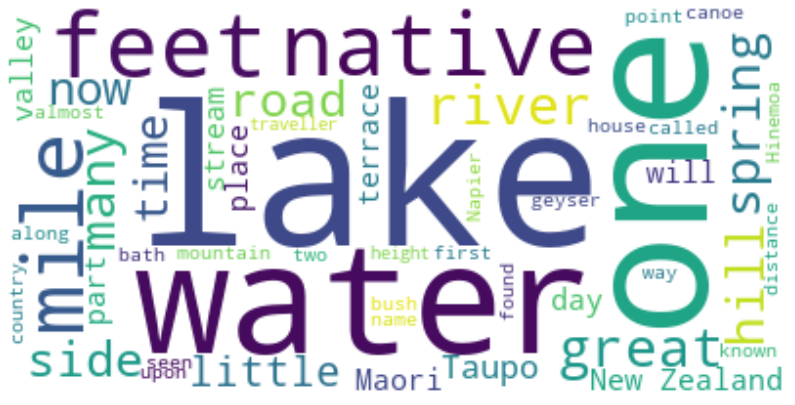

In [11]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

commons = []
for x in counts:
    commons.extend([x[0]]*x[1]) 
    
text = booktext

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(text)

# Display the generated image:
plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

A more insightful word cloud appears when we only consider named entities within the text.

In [12]:
# Create dictionary of frequencies for most common words
freq = {}
for c in counts:
    freq[c[0]] = c[1]

<Figure size 432x288 with 0 Axes>

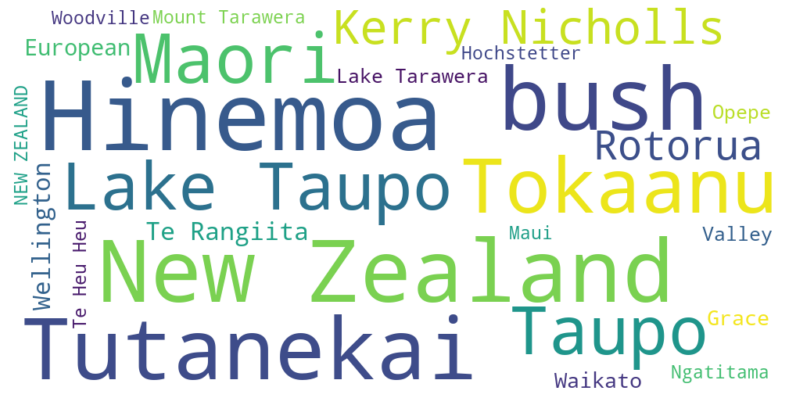

In [13]:
# Create and generate a word cloud image from a dictionary of most common words:
wordcloud = WordCloud(max_font_size=125, max_words=500, background_color="white", width = 1000, height = 500).generate_from_frequencies(freq)

# Display the generated image:
plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()